In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext Cython
%load_ext line_profiler
%load_ext memory_profiler


In [3]:
import sys, argparse, logging
import pymssql
import _mssql
from datetime import datetime, time
from decimal import Decimal
import pymongo
from pymongo import MongoClient
from tqdm import tqdm, tnrange, tqdm_notebook
import pandas as pd
from tmqr.settings import *
from tmqrfeed.assetsession import AssetSession
import pickle
import pytz
try:
    from tmqr.settings_local import *
except:
    pass
import pyximport

pyximport.install(setup_args={"include_dirs": np.get_include()})
from tmqrfeed.quotes.compress_daily_ohlcv import compress_daily
import os

from tmqrfeed.assetsession import AssetSession
from tmqrfeed.quotes.dataframegetter import DataFrameGetter
from tmqrfeed.datafeed import DataFeed

In [4]:
feed = DataFeed()

In [5]:
chain = feed.get_fut_chain("US.CL")
chain_values = chain.get_list(datetime(2011, 1, 1))

In [6]:
chain_values    

,date_end,date_start
ticker,,
US.F.CL.G11.110120,2011-01-18,2010-12-17
US.F.CL.H11.110222,2011-02-18,2011-01-18
US.F.CL.J11.110322,2011-03-18,2011-02-18
US.F.CL.K11.110419,2011-04-15,2011-03-18
US.F.CL.M11.110520,2011-05-18,2011-04-15
US.F.CL.N11.110622,2011-06-20,2011-05-18
US.F.CL.Q11.110720,2011-07-18,2011-06-20
US.F.CL.U11.110822,2011-08-18,2011-07-18
US.F.CL.V11.110921,2011-09-19,2011-08-18


In [7]:
fut = chain.get_contract(datetime(2012, 1, 1))
fut2 = chain.get_contract(datetime(2012, 1, 1), offset=1)

In [8]:
series1 = fut.get_series()
series2 = fut2.get_series()

In [9]:
series  = fut.get_series()

In [ ]:
series2

In [ ]:
prev_series, position1  = compress_daily(DataFrameGetter(series1), fut)
new_series, position2  = compress_daily(DataFrameGetter(series2), fut2)

In [ ]:
series1.to_csv('fut_series_for_contfut1.csv.gz', compression='gzip')

In [ ]:
series2.to_csv('fut_series_for_contfut2.csv.gz', compression='gzip')

In [ ]:
prev_series

In [ ]:
new_series.c.sum()

In [ ]:
prev_prices = prev_series.loc[prev_series.index[-1]]
new_prices = new_series.loc[prev_series.index[-1]]

In [ ]:
prev_prices

In [ ]:
new_prices

In [ ]:
fut_offset = new_prices['exec'] - prev_prices['exec']

In [ ]:
fut_offset

In [ ]:
new_series[['o','h','l', 'c', 'exec']] -= fut_offset

In [ ]:
new_series = new_series[new_series.index > prev_series.index[-1]]

In [ ]:
pd.concat([prev_series, new_series])

In [ ]:
def merge(prev_series, new_series):
    try:
        prev_prices = prev_series.loc[prev_series.index[-1]]
        new_prices = new_series.loc[prev_series.index[-1]]
        # Calculating futures rollover factor
        fut_offset = new_prices['exec'] - prev_prices['exec']
    except KeyError:
        fut_offset = 0.0
        
    new_series[['o','h','l', 'c', 'exec']] -= fut_offset
    new_series = new_series[new_series.index > prev_series.index[-1]]
    return pd.concat([prev_series, new_series])

In [ ]:
%timeit compress_daily(DataFrameGetter(series), fut)

In [ ]:
prev_series, position1  = compress_daily(DataFrameGetter(series), fut)
new_series, position2  = compress_daily(DataFrameGetter(series2), fut2)

In [ ]:
%lprun -f merge merge(prev_series, new_series)

In [ ]:
%timeit merge(prev_series, new_series)

In [ ]:
position1.at[position1.index[-1], 'qty'] = 0

In [ ]:
position1

In [ ]:
position2

In [ ]:
%%timeit
pd.merge(position2.reset_index(), position1.reset_index(), how='outer').sort_values('date').set_index(['date', 'asset'])

In [ ]:
position1.index.get_level_values('date')

In [10]:
from tmqrfeed.quotes.quote_contfut import QuoteContFut

In [28]:
qcont_fut = QuoteContFut('US.CL', datafeed=feed, timeframe='D')

In [ ]:
%lprun -m tmqrfeed.quotes.quote_contfut qcont_fut.build()

In [14]:
%timeit qcont_fut.build()

1 loop, best of 3: 2.62 s per loop


In [29]:
contfut_df, contfut_position = qcont_fut.build()

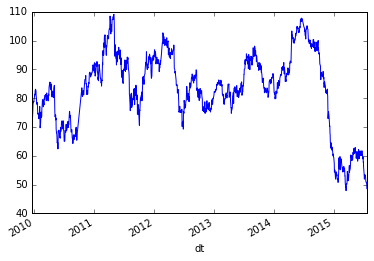

In [30]:
contfut_df.exec.plot()

In [22]:
contfut_position

,asset,exec_time,px,qty,quote_time
date,,,,,
2009-12-18 10:40:00-08:00,US.F.CL.G10.100120,2009-12-18 10:45:00-08:00,74.70,1,2009-12-18 10:44:00-08:00
2009-12-21 10:40:00-08:00,US.F.CL.G10.100120,2009-12-21 10:45:00-08:00,73.33,1,2009-12-21 10:44:00-08:00
2009-12-22 10:40:00-08:00,US.F.CL.G10.100120,2009-12-22 10:45:00-08:00,74.59,1,2009-12-22 10:44:00-08:00
2009-12-23 10:40:00-08:00,US.F.CL.G10.100120,2009-12-23 10:45:00-08:00,76.45,1,2009-12-23 10:44:00-08:00
2009-12-24 10:40:00-08:00,US.F.CL.G10.100120,2009-12-24 10:45:00-08:00,78.05,1,2009-12-24 10:44:00-08:00
2009-12-28 10:40:00-08:00,US.F.CL.G10.100120,2009-12-28 10:45:00-08:00,78.89,1,2009-12-28 10:44:00-08:00
2009-12-29 10:40:00-08:00,US.F.CL.G10.100120,2009-12-29 10:45:00-08:00,78.76,1,2009-12-29 10:44:00-08:00
2009-12-30 10:40:00-08:00,US.F.CL.G10.100120,2009-12-30 10:45:00-08:00,79.55,1,2009-12-30 10:44:00-08:00
2009-12-31 10:40:00-08:00,US.F.CL.G10.100120,2009-12-31 10:45:00-08:00,79.80,1,2009-12-31 10:44:00-08:00
